In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import joblib

In [54]:
uci = pd.read_csv("UCI_combined.csv")
uci_clean = uci.copy()

In [55]:
numeric_cols = ['age','trestbps','chol','thalch','oldpeak']
categorical_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']

In [56]:
for col in numeric_cols:
    if col in uci_clean.columns:
        uci_clean[col] = uci_clean[col].fillna(uci_clean[col].mean())

for col in categorical_cols:
    if col in uci_clean.columns:
        uci_clean[col] = uci_clean[col].fillna(uci_clean[col].mode()[0])

In [57]:
fram = pd.read_csv("framingham.csv")
fram_clean = fram.copy()

In [58]:
numeric_cols_fram = fram_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_fram = fram_clean.select_dtypes(exclude=[np.number]).columns.tolist()

In [59]:
for col in numeric_cols_fram:
    fram_clean[col] = fram_clean[col].fillna(fram_clean[col].mean())
for col in categorical_cols_fram:
    fram_clean[col] = fram_clean[col].fillna(fram_clean[col].mode()[0])

In [60]:
def encode_and_scale(df, target_col):
    df = df.copy()
    le = LabelEncoder()
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = le.fit_transform(df[col])
    
    scaler = StandardScaler()
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    X[X.columns] = scaler.fit_transform(X)
    
    return X, y

In [61]:
X_uci, y_uci = encode_and_scale(uci_clean, "target")
X_fram, y_fram = encode_and_scale(fram_clean, "TenYearCHD")

In [62]:
rf_uci = RandomForestClassifier(n_estimators=200, random_state=42)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [63]:
uci_acc_scores = cross_val_score(rf_uci, X_uci, y_uci, cv=kf, scoring='accuracy')
uci_roc_scores = cross_val_score(rf_uci, X_uci, y_uci, cv=kf, scoring='roc_auc')

In [64]:
print("UCI-RF CV Accuracy:", np.mean(uci_acc_scores))
print("UCI-RF CV ROC-AUC:", np.mean(uci_roc_scores))

UCI-RF CV Accuracy: 0.9336134453781513
UCI-RF CV ROC-AUC: 0.9676380681476131


In [65]:
rf_uci.fit(X_uci, y_uci)

RandomForestClassifier(n_estimators=200, random_state=42)

In [66]:
rf_fram = RandomForestClassifier(n_estimators=200, random_state=42)

In [67]:
fram_acc_scores = cross_val_score(rf_fram, X_fram, y_fram, cv=kf, scoring='accuracy')
fram_roc_scores = cross_val_score(rf_fram, X_fram, y_fram, cv=kf, scoring='roc_auc')

In [68]:
print("Framingham-RF CV Accuracy:", np.mean(fram_acc_scores))
print("Framingham-RF CV ROC-AUC:", np.mean(fram_roc_scores))

Framingham-RF CV Accuracy: 0.8502358490566039
Framingham-RF CV ROC-AUC: 0.7005246343929805


In [69]:
rf_fram.fit(X_fram, y_fram)

RandomForestClassifier(n_estimators=200, random_state=42)

In [70]:
joblib.dump(rf_uci, "../model/model_uci.pkl")
joblib.dump(rf_fram, "../model/model_fram.pkl")

['../model/model_fram.pkl']

### Creating a meta Model

In [71]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
import joblib

In [72]:
meta_dataset = pd.read_csv("meta_dataset.csv")

In [73]:
X_meta = meta_dataset[['p_uci', 'p_fram']]
y_meta = meta_dataset['y']

In [74]:
meta_model = LogisticRegression()

In [75]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [76]:
accuracy_scores = cross_val_score(meta_model, X_meta, y_meta, cv=kf, scoring='accuracy')

In [77]:
roc_auc_scores = cross_val_score(meta_model, X_meta, y_meta, cv=kf, scoring='roc_auc')

In [78]:
print("CV Accuracy scores:", accuracy_scores)
print("Mean CV Accuracy:", np.mean(accuracy_scores))
print("CV ROC-AUC scores:", roc_auc_scores)
print("Mean CV ROC-AUC:", np.mean(roc_auc_scores))

CV Accuracy scores: [0.8440367  0.8202765  0.84331797 0.82488479 0.78801843]
Mean CV Accuracy: 0.8241068786200483
CV ROC-AUC scores: [0.80051661 0.75224427 0.78065202 0.71243799 0.59652695]
Mean CV ROC-AUC: 0.728475567645715


In [79]:
meta_model.fit(X_meta, y_meta)
print("Meta-model trained on full data.")

Meta-model trained on full data.


In [80]:
joblib.dump(meta_model, "../model/meta_model.pkl")

['../model/meta_model.pkl']

In [81]:
uci_prob = 0.43
fram_prob = 0.67

meta_input = pd.DataFrame([[uci_prob, fram_prob]], columns=['p_uci', 'p_fram'])

final_prob = meta_model.predict_proba(meta_input)[0][1]
final_class = meta_model.predict(meta_input)[0]

print("Final Meta-model Probability:", final_prob)
print("Final Meta-model Prediction:", final_class)

if final_class == 0:
    print(f"No signs of heart disease (Probability: {final_prob:.2f})")
else:
    print(f"Potential heart disease risk (Probability: {final_prob:.2f})")

Final Meta-model Probability: 0.491535384621411
Final Meta-model Prediction: 0
No signs of heart disease (Probability: 0.49)


### Scaler models

In [82]:
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

uci_df = pd.read_csv("UCI_combined.csv")
fram_df = pd.read_csv("framingham.csv")

X_uci = uci_df.drop(columns=["target"])
X_fram = fram_df.drop(columns=["TenYearCHD"])

scaler_uci = StandardScaler()
scaler_fram = StandardScaler()

scaler_uci.fit(X_uci)
scaler_fram.fit(X_fram)

joblib.dump(scaler_uci, "../model/scaler_uci.pkl")
joblib.dump(scaler_fram, "../model/scaler_fram.pkl")

['../model/scaler_fram.pkl']

### Test

In [83]:
import pandas as pd
import joblib

In [84]:
rf_uci = joblib.load("../model/model_uci.pkl")
rf_fram = joblib.load("../model/model_fram.pkl")
meta_model = joblib.load("../model/meta_model.pkl")

In [85]:
user_input = {
    'age': 58,
    'sex': 1,
    'chest pain type': 3,
    'resting bp s': 145,
    'cholesterol': 233,
    'fasting blood sugar': 0,
    'resting ecg': 0,
    'max heart rate': 150,
    'exercise angina': 0,
    'oldpeak': 2.0,
    'ST slope': 1,
    'sysBP': 140,
    'diaBP': 90,
    'BMI': 27.5,
    'totChol': 250,
    'heartRate': 78,
    'glucose': 85,
    'education': 2,
    'currentSmoker': 1,
    'cigsPerDay': 10,
    'BPMeds': 0,
    'prevalentStroke': 0,
    'prevalentHyp': 1,
    'diabetes': 0
}

In [86]:
uci_features = ['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol', 
                'fasting blood sugar', 'resting ecg', 'max heart rate', 
                'exercise angina', 'oldpeak', 'ST slope']

In [87]:
fram_features = ['age', 'sysBP', 'diaBP', 'BMI', 'totChol', 'heartRate', 'glucose']

In [88]:
uci_input = {k: user_input.get(k, 0) for k in uci_features}
fram_input = {k: user_input.get(k, 0) for k in fram_features}
uci_df = pd.DataFrame([uci_input]) 

In [89]:
uci_model_features = rf_uci.feature_names_in_
uci_df = uci_df.reindex(columns=uci_model_features, fill_value=0)
uci_prob = rf_uci.predict_proba(uci_df)[0][1]
fram_df = pd.DataFrame([fram_input])

In [90]:
fram_model_features = rf_fram.feature_names_in_
fram_df = fram_df.reindex(columns=fram_model_features, fill_value=0)
fram_prob = rf_fram.predict_proba(fram_df)[0][1]

In [91]:
print(f"UCI RF Probability: {uci_prob:.4f}")
print(f"Framingham RF Probability: {fram_prob:.4f}")

UCI RF Probability: 0.5350
Framingham RF Probability: 0.6050


In [92]:
meta_input = pd.DataFrame([[uci_prob, fram_prob]], columns=['p_uci', 'p_fram'])

In [93]:
final_prob = meta_model.predict_proba(meta_input)[0][1]

In [94]:
threshold = 0.5
final_pred = 1 if final_prob >= threshold else 0

In [95]:
print(f"Final Meta-model Probability: {final_prob:.4f}")
print(f"Final Meta-model Prediction: {final_pred}")

Final Meta-model Probability: 0.5868
Final Meta-model Prediction: 1


# Confusion Matrix

In [96]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

# UCI RF with cross-validated predictions
y_pred_uci_cv = cross_val_predict(rf_uci, X_uci, y_uci, cv=5)
print(confusion_matrix(y_uci, y_pred_uci_cv))
print(classification_report(y_uci, y_pred_uci_cv))

# Framingham RF
y_pred_fram_cv = cross_val_predict(rf_fram, X_fram, y_fram, cv=5)
print(confusion_matrix(y_fram, y_pred_fram_cv))
print(classification_report(y_fram, y_pred_fram_cv))

# Meta-model
y_pred_meta_cv = cross_val_predict(meta_model, X_meta, y_meta, cv=5)
print(confusion_matrix(y_meta, y_pred_meta_cv))
print(classification_report(y_meta, y_pred_meta_cv))


[[511  50]
 [ 35 594]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       561
           1       0.92      0.94      0.93       629

    accuracy                           0.93      1190
   macro avg       0.93      0.93      0.93      1190
weighted avg       0.93      0.93      0.93      1190

[[3564   32]
 [ 610   34]]
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      3596
           1       0.52      0.05      0.10       644

    accuracy                           0.85      4240
   macro avg       0.68      0.52      0.51      4240
weighted avg       0.80      0.85      0.79      4240

[[779  53]
 [139 115]]
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       832
           1       0.68      0.45      0.55       254

    accuracy                           0.82      1086
   macro avg       0.77      0.69      0.72      1086
w

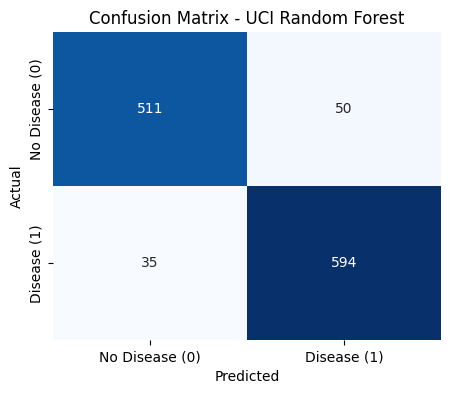

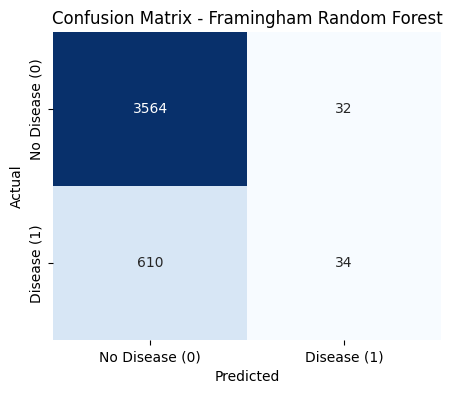

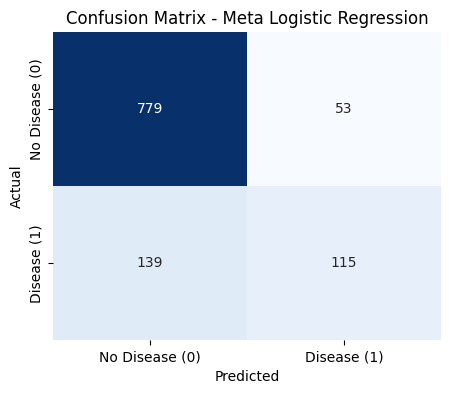

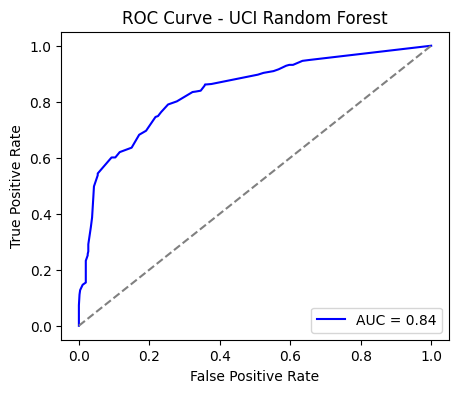

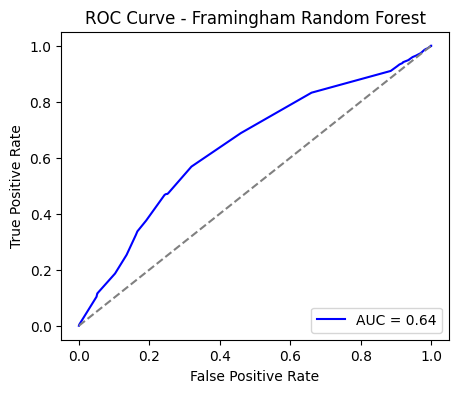

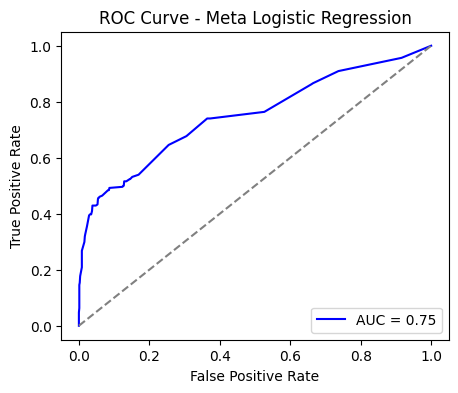

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# --- Function to plot confusion matrix ---
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No Disease (0)", "Disease (1)"],
                yticklabels=["No Disease (0)", "Disease (1)"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

# --- Function to plot ROC curve ---
def plot_roc_curve(model, X, y, title):
    y_prob = model.predict_proba(X)[:, 1]  # Probabilities for class 1
    fpr, tpr, thresholds = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {title}")
    plt.legend(loc="lower right")
    plt.show()


# ---- Plot Confusion Matrices ----
plot_confusion_matrix(y_uci, y_pred_uci_cv, "UCI Random Forest")
plot_confusion_matrix(y_fram, y_pred_fram_cv, "Framingham Random Forest")
plot_confusion_matrix(y_meta, y_pred_meta_cv, "Meta Logistic Regression")

# ---- Plot ROC Curves ----
plot_roc_curve(rf_uci, X_uci, y_uci, "UCI Random Forest")
plot_roc_curve(rf_fram, X_fram, y_fram, "Framingham Random Forest")
plot_roc_curve(meta_model, X_meta, y_meta, "Meta Logistic Regression")


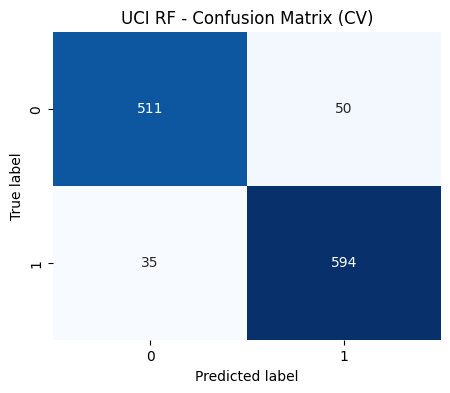

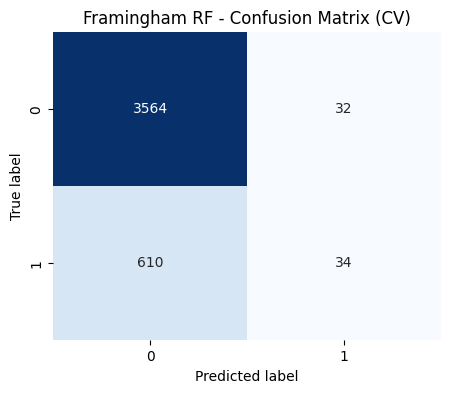

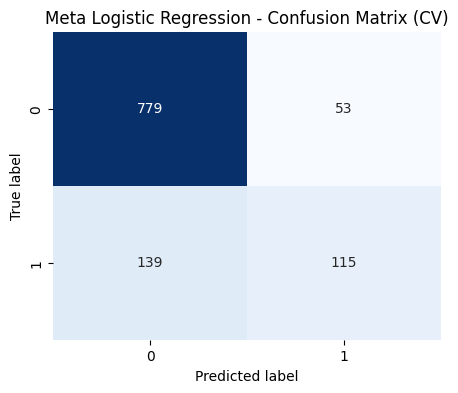

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_cv(model, X, y, cv=5, model_name="Model"):
    # Cross-validated predictions
    y_pred = cross_val_predict(model, X, y, cv=cv)
    
    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"{model_name} - Confusion Matrix (CV)")
    plt.show()
    
    return cm

# --- Run for each model ---
cm_uci = plot_confusion_matrix_cv(rf_uci, X_uci, y_uci, cv=5, model_name="UCI RF")
cm_fram = plot_confusion_matrix_cv(rf_fram, X_fram, y_fram, cv=5, model_name="Framingham RF")
cm_meta = plot_confusion_matrix_cv(meta_model, X_meta, y_meta, cv=5, model_name="Meta Logistic Regression")


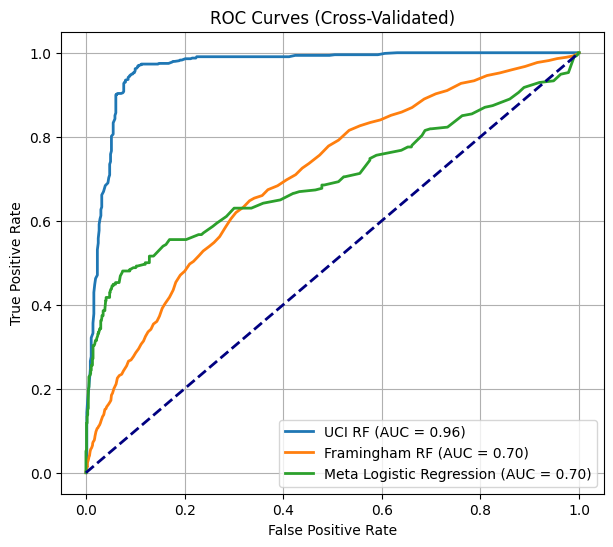

In [105]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc

def plot_roc_curve_cv(model, X, y, cv=5, model_name="Model"):
    # Cross-validated predicted probabilities
    y_pred_proba = cross_val_predict(model, X, y, cv=cv, method="predict_proba")[:, 1]
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")
    return fpr, tpr, roc_auc

plt.figure(figsize=(7,6))

# --- Run for each model ---
plot_roc_curve_cv(rf_uci, X_uci, y_uci, cv=5, model_name="UCI RF")
plot_roc_curve_cv(rf_fram, X_fram, y_fram, cv=5, model_name="Framingham RF")
plot_roc_curve_cv(meta_model, X_meta, y_meta, cv=5, model_name="Meta Logistic Regression")

# Diagonal reference line
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Cross-Validated)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### AUC-ROC graph

In [97]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [98]:
y_proba_uci = rf_uci.predict_proba(X_uci)[:, 1]
fpr_uci, tpr_uci, _ = roc_curve(y_uci, y_proba_uci)
roc_auc_uci = auc(fpr_uci, tpr_uci)

In [99]:
y_proba_fram = rf_fram.predict_proba(X_fram)[:, 1]
fpr_fram, tpr_fram, _ = roc_curve(y_fram, y_proba_fram)
roc_auc_fram = auc(fpr_fram, tpr_fram)

In [100]:
y_proba_meta = meta_model.predict_proba(X_meta)[:, 1]
fpr_meta, tpr_meta, _ = roc_curve(y_meta, y_proba_meta)
roc_auc_meta = auc(fpr_meta, tpr_meta)

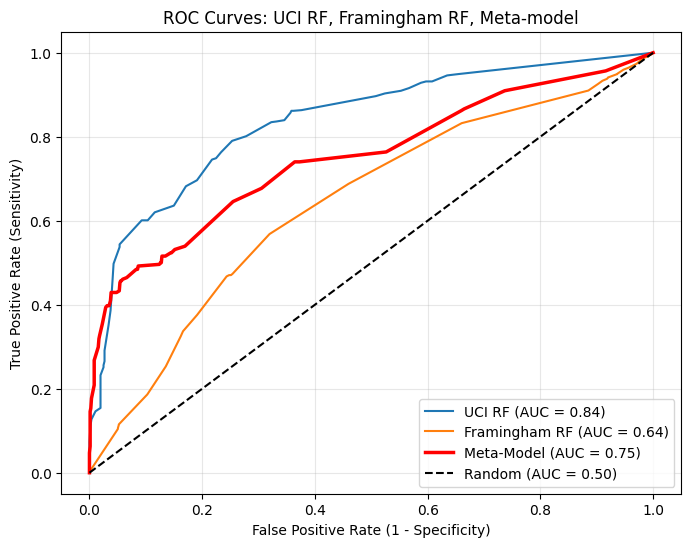

In [101]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_uci, tpr_uci, label=f"UCI RF (AUC = {roc_auc_uci:.2f})")
plt.plot(fpr_fram, tpr_fram, label=f"Framingham RF (AUC = {roc_auc_fram:.2f})")
plt.plot(fpr_meta, tpr_meta, label=f"Meta-Model (AUC = {roc_auc_meta:.2f})", linewidth=2.5, color="red")

plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.50)")

plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curves: UCI RF, Framingham RF, Meta-model")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()